## Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

In [6]:
%pip install wget

In [10]:
!python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv


Saved under housing.csv


In [9]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
#from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Loading the data

Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

In [10]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv('housing.csv', usecols=select_cols)


### Inspect Data

In [11]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [12]:
#Fill N/A with 0
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [13]:
df.describe().round()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0,20640.0
mean,-120.0,36.0,29.0,2636.0,532.0,1425.0,500.0,4.0,206856.0
std,2.0,2.0,13.0,2182.0,423.0,1132.0,382.0,2.0,115396.0
min,-124.0,33.0,1.0,2.0,0.0,3.0,1.0,0.0,14999.0
25%,-122.0,34.0,18.0,1448.0,292.0,787.0,280.0,3.0,119600.0
50%,-118.0,34.0,29.0,2127.0,431.0,1166.0,409.0,4.0,179700.0
75%,-118.0,38.0,37.0,3148.0,643.0,1725.0,605.0,5.0,264725.0
max,-114.0,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


### Train/Test/Val

In [15]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [23]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Apply DictVectorizer for OneHotEncoding

In [37]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')


In [38]:

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)


## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity=INLAND`
* `total_rooms`
* `latitude`
* `population`

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text


dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1)

In [34]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- median_house_value <= 12.06
|   |--- value: [11.60]
|--- median_house_value >  12.06
|   |--- value: [12.52]



Answer: `room_type`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
RMSE =np.sqrt(mean_squared_error(y_val, y_pred))
round(RMSE,2)

0.25

Answer: 0.25

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 150

In [42]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104
5,60,0.232843
6,70,0.232384
7,80,0.232527
8,90,0.232215
9,100,0.231968


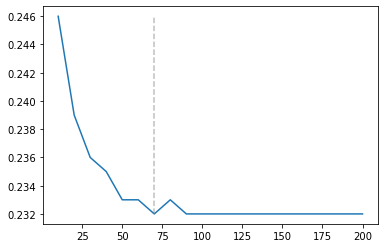

In [49]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.vlines(70, 0.232, 0.246, color='grey', linestyle='--', alpha=0.5)


Answer: 70

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25


In [51]:
scores = []

for d in [10, 15, 20, 25]:
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

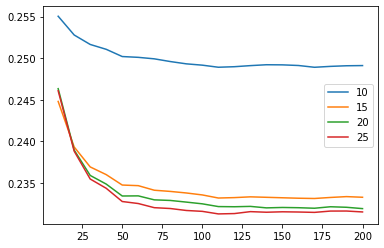

In [52]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

Answer: 10

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `total_rooms`
* `median_income`	
* `total_bedrooms`
* `longitude`

In [53]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [56]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False)

c:\Users\user\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


Answer: median_income

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same

In [60]:
features = dv.get_feature_names()
features= [i.replace("=<", "_").replace("=","_") for i in features]

In [68]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [69]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [112]:
def parse_xgb_output(evals_result):
    columns = ['iter', 'train_rmse', 'val_rmse']
    train_rmse = list(evals_result['train'].values())[0]
    val_rmse = list(evals_result['val'].values())[0]

    df_scores = pd.DataFrame(
        list(zip(
            range(1, len(train_rmse)),
            train_rmse,
            val_rmse
        )), columns=columns)
    return df_scores

In [113]:
xgb_base_params = { 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

eta_1 ={'eta': 0.3}
eta_2 ={'eta': 0.1}

xgb_params_1 = xgb_base_params|eta_1
xgb_params_2 = xgb_base_params|eta_2

In [114]:
scores = {}

In [115]:
params =[('eta=0.3',xgb_params_1),('eta=0.1',xgb_params_2)] 

for eta,xgb_params in params:
    evals_result = {}

    model = xgb.train(params=xgb_params,
                    dtrain=dtrain,
                    num_boost_round=100,
                    verbose_eval=5,
                    evals=watchlist,
                    evals_result=evals_result) 

    scores[eta] = parse_xgb_output(evals_result)
    


[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.24624
[25]	train-rmse:0.20395	val-rmse:0.24099
[30]	train-rmse:0.19440	val-rmse:0.23741
[35]	train-rmse:0.18637	val-rmse:0.23562
[40]	train-rmse:0.17983	val-rmse:0.23419
[45]	train-rmse:0.17468	val-rmse:0.23279
[50]	train-rmse:0.16934	val-rmse:0.23097
[55]	train-rmse:0.16546	val-rmse:0.23039
[60]	train-rmse:0.16177	val-rmse:0.22950
[65]	train-rmse:0.15762	val-rmse:0.22857
[70]	train-rmse:0.15323	val-rmse:0.22787
[75]	train-rmse:0.15010	val-rmse:0.22755
[80]	train-rmse:0.14564	val-rmse:0.22611
[85]	train-rmse:0.14166	val-rmse:0.22579
[90]	train-rmse:0.13892	val-rmse:0.22628
[95]	train-rmse:0.13553	val-rmse:0.22630
[99]	train-rmse:0.13299	val-rmse:0.22610
[0]	train-rmse:10.44372	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-rmse:2.

Text(0, 0.5, 'rmse')

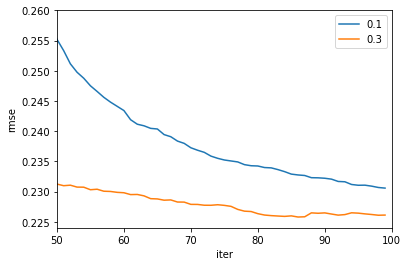

In [118]:
plt.plot(scores['eta=0.1'].iter, scores['eta=0.1'].val_rmse,
        label='0.1')
plt.plot(scores['eta=0.3'].iter, scores['eta=0.3'].val_rmse,
        label='0.3')
plt.legend()
plt.ylim([0.224, 0.26])
plt.xlim([50, 100])
plt.xlabel('iter')
plt.ylabel('rmse')

Answer: 0.3 is better